In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import sklearn
import collections
from sklearn.model_selection import train_test_split
import json
import pylab
import tensorflow as tf                                        
import tensorflow.math as tfmath
import tensorflow.keras as keras
from scipy.optimize import curve_fit
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as sk

2024-10-14 01:54:53.669156: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-14 01:54:53.884281: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import PReLU, Input, LSTM, Flatten, Concatenate, Dense, Conv2D, TimeDistributed, MaxPooling2D, ReLU, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Precision
from qkeras import QActivation, QDense, QConv2D, QBatchNormalization, QConv2DBatchnorm
from qkeras import quantized_relu, quantized_bits
from tensorflow.keras.regularizers import l1, l2, l1_l2

In [3]:
# Import math Library
import math
phi_res = 128/(2*math.pi)
print(phi_res)

20.371832715762604


In [4]:
def load_and_preprocess_data(file_path):
    with h5py.File(file_path, 'r') as hf:
        # Define object counts
        nmuon, nLRjet, nSRjet, negamma, netau, njtau = 4, 6, 6, 4, 4, 4

        # Load and reshape datasets with scaling
        def load_and_scale(dataset, n_objects, scale_factor=10, eta_factor=10, phi_factor = phi_res):
            data = hf[dataset][:, 0:n_objects, :]
            data[:, :, 0] *= scale_factor  # Scale the pT value
            data[:, :, 1] *= eta_factor  # Scale the angle value
            data[:, :, 2] *= phi_factor  # Scale the angle value
            return data.reshape(-1, 3 * n_objects)

        L1_jFexSR_jets = load_and_scale('L1_jFexSR_jets', nSRjet)
        L1_jFexLR_jets = load_and_scale('L1_jFexLR_jets', nLRjet)
        L1_egammas = load_and_scale('L1_egammas', negamma)
        L1_muons = load_and_scale('L1_muons', nmuon, scale_factor=10000)
        L1_eFex_taus = load_and_scale('L1_eFex_taus', netau)
        L1_jFex_taus = load_and_scale('L1_jFex_taus', njtau)

        # Load and process MET
        L1_MET = hf['L1_MET'][:]
        L1_MET[:, 0] *= 10
        L1_MET[:, 2] *= phi_res
        print(L1_MET)
        percentage_zeros = np.mean(L1_MET[:, 1] == 0) * 100
        print(f"Percentage of rows where both second and third components are zero: {percentage_zeros:.2f}%")

        L1_MET_fixed = np.zeros((L1_MET.shape[0], 2))
        L1_MET_fixed[:, 0] = L1_MET[:, 0]
        L1_MET_fixed[:, 1] = L1_MET[:, 2]
        L1_MET = L1_MET_fixed

        pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
        # Combine arrays into Topo groups
        Topo_2A = np.concatenate([L1_jFexSR_jets, L1_eFex_taus, L1_muons, L1_MET], axis=1)
        Topo_2B = np.concatenate([L1_jFexSR_jets, L1_egammas, L1_jFex_taus, L1_MET], axis=1)
        Topo_3A = np.concatenate([L1_jFexSR_jets, L1_egammas, L1_eFex_taus, L1_MET], axis=1)

        Topo_2A_labels = ['L1_jFexSR_jets', 'L1_eFex_taus', 'L1_muons', 'L1_MET']
        Topo_2B_labels = ['L1_jFexSR_jets', 'L1_egammas', 'L1_jFex_taus', 'L1_MET']
        Topo_3A_labels = ['L1_jFexSR_jets', 'L1_egammas', 'L1_eFex_taus', 'L1_MET']

        # Print shapes
        print("Shape of Topo_2A:", Topo_2A.shape)
        print("Shape of Topo_2B:", Topo_2B.shape)
        print("Shape of Topo_3A:", Topo_3A.shape)

        return Topo_2A, Topo_2B, Topo_3A, Topo_2A_labels, Topo_2B_labels, Topo_3A_labels, pass_L1_unprescaled

# Usage
file_path = '/eos/home-m/mmcohen/ntuples/EB_ntuples_08-13-2024.h5'
Topo_2A, Topo_2B, Topo_3A, Topo_2A_labels, Topo_2B_labels, Topo_3A_labels, pass_L1_unprescaled = load_and_preprocess_data(file_path)

# Print the shapes of the combined datasets to verify
print("Shape of Topo_2A:", Topo_2A.shape)
print("Shape of Topo_2B:", Topo_2B.shape)
print("Shape of Topo_3A:", Topo_3A.shape)

[[ 62.22539425   0.          16.00000045]
 [ 56.88584805   0.           3.59988338]
 [120.           0.          13.10929682]
 ...
 [418.69319916   0.          25.5684422 ]
 [ 95.01579285   0.         -14.48252669]
 [114.1577816    0.          62.92878527]]
Percentage of rows where both second and third components are zero: 100.00%
Shape of Topo_2A: (2104833, 44)
Shape of Topo_2B: (2104833, 44)
Shape of Topo_3A: (2104833, 44)
Shape of Topo_2A: (2104833, 44)
Shape of Topo_2B: (2104833, 44)
Shape of Topo_3A: (2104833, 44)


In [5]:
Topo_2A_test=Topo_2A[0:450000,:]
Topo_2B_test=Topo_2B[0:450000,:]
Topo_3A_test=Topo_3A[0:450000,:]

def replace_nan_with_median(data):
    # Ensure the input is a numpy array
    data = np.asarray(data)
    
    # Number of variables (columns)
    num_variables = data.shape[1]
    
    # Iterate over each variable
    for i in range(num_variables):
        # Compute the median of the i-th variable, ignoring NaNs
        median = np.nanmedian(data[:, i])
        
        # Find NaN indices in the column
        nan_indices = np.where(np.isnan(data[:, i]))[0]
        
        for index in nan_indices:
            print(f"NaN found at index {index}, variable {i}")
        
        # Replace NaNs with the median of the respective variable
        data[nan_indices, i] = 0 #median
    
    return data
Topo_2A_test = replace_nan_with_median(Topo_2A_test)
Topo_2B_test = replace_nan_with_median(Topo_2B_test)
Topo_3A_test = replace_nan_with_median(Topo_3A_test)

In [6]:
L1_pass_test = pass_L1_unprescaled[0:450000]
Topo_2A_test_L1failed = Topo_2A_test[L1_pass_test==0]

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(Topo_2A_test_L1failed)


StandardScaler()

In [8]:
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

In [9]:
mean = scaler.mean_
std = scaler.scale_
print("Mean (bias):", mean)
print("Standard deviation (scale):", std)
def closest_power_of_2(arr):
    return [int(round(math.log2(max(abs(x), 1e-10)))) for x in arr]
result = closest_power_of_2(std)
print(result)

Mean (bias): [ 1.37059273e+02 -4.86769911e+00 -9.46810177e+00  4.85459573e+01
 -3.24937547e-01 -1.16911069e-01  1.75623307e+01 -2.10871678e-01
 -1.68209852e-02  6.51239141e+00 -1.43792254e-01 -2.19732727e-02
  2.77885690e+00 -7.28731674e-02 -1.04450144e-02  1.27396794e+00
 -4.36500536e-02 -5.94211477e-04  7.40582360e+01 -3.37643003e+00
 -7.17464982e+00  1.69404890e+01  2.01246246e-02  1.69780653e-02
  5.19381558e+00  5.17336679e-03  2.70554901e-02  1.72618046e+00
  4.32557310e-03  2.97953787e-02  8.64337910e+00  4.28261578e-01
  2.50242003e-01  9.89359217e-01  4.15462038e-02  1.37360196e-01
  1.52054791e-01  2.68545224e-03  7.58716854e-03  8.27191250e-03
  8.73627822e-06  2.66059417e-03  1.11481399e+02 -1.63352904e+00]
Standard deviation (scale): [211.51534862  13.25633925  28.70625018 134.06044535   7.45020399
  14.63370363  64.31877996   5.75199839  10.34238344  35.28293775
   4.1423674    6.92113264  22.52426842   2.93402333   4.6775563
  15.07186591   2.1279519    3.20552072  94.27

In [10]:
def apply_power_of_2_scaling(X, result):
    
    # Apply the scaling using 2 raised to the power of the result
    X_scaled = X / (2.0 ** np.array(result))
    
    return X_scaled
Topo_2A_test_L1failed = apply_power_of_2_scaling(Topo_2A_test_L1failed, result)

In [11]:
print("Shape of Topo_2A:", Topo_2A.shape)
print("Shape of Topo_2B:", Topo_2B.shape)
print("Shape of Topo_3A:", Topo_3A.shape)
print(Topo_2A_test_L1failed)

Shape of Topo_2A: (2104833, 44)
Shape of Topo_2B: (2104833, 44)
Shape of Topo_3A: (2104833, 44)
[[ 0.625      -1.46874994 -1.59374997 ...  0.          0.97227179
   0.50000001]
 [ 0.625      -1.46874994 -1.59374997 ...  0.          0.88884138
   0.11249636]
 [ 0.625      -1.46874994 -1.59374997 ...  0.          1.875
   0.40966553]
 ...
 [ 1.42968744 -0.21875     0.28125    ...  0.          0.88884138
  -1.11249635]
 [ 0.9375     -0.21875    -0.40625001 ...  0.          0.72146222
   1.80388757]
 [ 0.          0.          0.         ...  0.          0.98126993
   1.58627956]]


In [12]:
class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def Qmake_encoder_set_weights(input_dim,h_dim_1,h_dim_2,latent_dim):
    l2_factor = 1e-3
    inputs = keras.Input(shape=(input_dim))
    x = QDense(h_dim_1,
             kernel_quantizer=quantized_bits(10,5,0,alpha=1),
             bias_quantizer=quantized_bits(10,5,0,alpha=1),
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(inputs)
    x = QBatchNormalization(name="BN1")(x)
    x = QActivation(quantized_relu(15, negative_slope=1/1024))(x)
    x = QDense(h_dim_2,
             kernel_quantizer=quantized_bits(10,5,0,alpha=1),
             bias_quantizer=quantized_bits(10,5,0,alpha=1),
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)    
    x = QBatchNormalization(name="BN2")(x)
    x = QActivation(quantized_relu(15, negative_slope=1/1024))(x)
    z_mean=QDense(latent_dim, name='z_mean',
                  kernel_quantizer=quantized_bits(10,5,0,alpha=1),
                  bias_quantizer=quantized_bits(10,5,0,alpha=1),
                  kernel_initializer=keras.initializers.HeNormal(seed=None),
                  bias_initializer=keras.initializers.Zeros(),
                  kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    z_logvar=Dense(latent_dim, name='z_log_var',
                          kernel_initializer=keras.initializers.Zeros(),
                          bias_initializer=keras.initializers.Zeros(),
                          kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    z=Sampling()([z_mean,z_logvar])
    encoder = keras.Model(inputs,[z_mean,z_logvar,z],name='encoder')
    return encoder

def Qmake_decoder_set_weights(input_dim,h_dim_1,h_dim_2,latent_dim):
    l2_factor = 1e-3
    inputs=keras.Input(shape=(latent_dim))
    x=layers.Dense(h_dim_2,
                   activation='relu',
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(inputs)
    x=layers.Dense(h_dim_1,
                   activation='relu',
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    z=layers.Dense(input_dim,
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    decoder=keras.Model(inputs,z,name='decoder')
    return decoder
def custom_mse_loss_with_multi_index_scaling(masked_data, masked_reconstruction):
#     jet_scale = 1024/800
#     tau_scale = 1024/800
#     muon_sacle = 64/800
#     met_scale = 8192/800
    jet_scale = 1
    tau_scale = 1
    muon_sacle = 1
    met_scale = 1

    # Define the indices and their corresponding scale factors
    scale_dict = {
        0: jet_scale,
        3: jet_scale,
        6: jet_scale,
        9: jet_scale,
        12: jet_scale,
        15: jet_scale,
        18: tau_scale,
        21: tau_scale,
        24: tau_scale,
        27: tau_scale,
        30: muon_sacle,
        33: muon_sacle,
        36: muon_sacle,
        39: muon_sacle,
        42: met_scale
    }
    
    # Create the scaling tensor
    scale_tensor = tf.ones_like(masked_data)
    
    for index, factor in scale_dict.items():
        # Create a mask for the current index
        index_mask = tf.one_hot(index, depth=tf.shape(masked_data)[-1])
        # Update the scale tensor for this index
        scale_tensor += index_mask * (factor - 1)
    
    # Apply scaling
    scaled_data = masked_data * scale_tensor
    scaled_reconstruction = masked_reconstruction * scale_tensor
    
#     # Hardcoded lists for eta and phi indices
#     eta_indices = [1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40]
#     phi_indices = [2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 43]

#     batch_size = tf.shape(scaled_reconstruction)[0]
    
#     # Apply constraints to eta
#     for i in eta_indices:
#         indices = tf.stack([tf.range(batch_size), tf.fill([batch_size], i)], axis=1)
#         updates = 3 * tf.tanh(scaled_reconstruction[:, i] / 3)
#         scaled_reconstruction = tf.tensor_scatter_nd_update(scaled_reconstruction, indices, updates)
    
#     # Apply constraints to phi
#     for i in phi_indices:
#         indices = tf.stack([tf.range(batch_size), tf.fill([batch_size], i)], axis=1)
#         updates = 3.14159265258979*(10/8) * tf.tanh(scaled_reconstruction[:, i] / (3.14159265258979*(10/8)))
#         scaled_reconstruction = tf.tensor_scatter_nd_update(scaled_reconstruction, indices, updates)
    # Calculate MSE using keras.losses.mse
    mse = keras.losses.mse(scaled_data, scaled_reconstruction)
    
    # Take the mean across all dimensions
    return tf.reduce_mean(mse)

class VAE_Model(keras.Model):
    def __init__(self, encoder, decoder, steps_per_epoch, cycle_length=10, min_beta=0.1, max_beta=0.85, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta_tracker = keras.metrics.Mean(name="beta")
        self.steps_per_epoch = steps_per_epoch
        self.cycle_length = tf.cast(cycle_length, tf.float32)
        self.min_beta = tf.cast(min_beta, tf.float32)
        self.max_beta = tf.cast(max_beta, tf.float32)
        self.beta = tf.Variable(min_beta, dtype=tf.float32)


    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.beta_tracker,
        ]

    def cyclical_annealing_beta(self, epoch):
        cycle = tf.floor(1.0 + epoch / self.cycle_length)
        x = tf.abs(epoch / self.cycle_length - cycle + 1)
        return self.min_beta + (self.max_beta - self.min_beta) * tf.minimum(x, 1.0)
#     def set_beta(self,beta):
#         self.beta=beta

    def train_step(self, data):
        # Get the current epoch number
        epoch = tf.cast(self.optimizer.iterations / self.steps_per_epoch, tf.float32)
        
        # Update beta
        self.beta.assign(self.cyclical_annealing_beta(epoch))
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            mask = K.cast(K.not_equal(data, 0), K.floatx())
#             reconstruction_loss = tf.reduce_mean(keras.losses.mse(mask*data, mask*reconstruction))
            reconstruction_loss = custom_mse_loss_with_multi_index_scaling(mask*data, mask*reconstruction)
            reconstruction_loss *=(1-self.beta)

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *=self.beta

            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reco_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "beta": self.beta,
        }

    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        mask = K.cast(K.not_equal(data, 0), K.floatx())
        reconstruction_loss = custom_mse_loss_with_multi_index_scaling(mask*data, mask*reconstruction)
#         reconstruction_loss = tf.reduce_mean(keras.losses.mse(mask*data, mask*reconstruction))
        reconstruction_loss*=(1-self.beta)

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss)        
        kl_loss *=self.beta
        
        total_loss = reconstruction_loss + kl_loss
        
        return {
            "loss": total_loss,
            "reco_loss": reconstruction_loss,
            "kl_loss": kl_loss,
            "beta": self.beta,
        }

    def call(self, data):
        z_mean,z_log_var,x = self.encoder(data)
        reconstruction = self.decoder(x)
        return {
            "z_mean": z_mean,
            "z_log_var": z_log_var,
            "reconstruction": reconstruction
        }

        
 

In [13]:
def weighted_mse(y_true, y_pred, sample_weight):
    return tf.reduce_mean(tf.multiply(sample_weight, tf.square(y_true - y_pred)))

In [14]:
NUM_EPOCHS = 100
BATCH_SIZE = 1024
STOP_PATIENCE = 30
LR_PATIENCE = 10

In [19]:
#TOPO 2A Trainer

T2A_enc = Qmake_encoder_set_weights(Topo_2A.shape[1],32,16,3)
T2A_dec = Qmake_decoder_set_weights(Topo_2A.shape[1],32,16,3)
steps_per_epoch = Topo_2A_test_L1failed.shape[0] // BATCH_SIZE
T2A = VAE_Model(T2A_enc, T2A_dec, steps_per_epoch=steps_per_epoch, min_beta=0.1, max_beta=0.7)
# T2A.set_beta(beta)
opt = keras.optimizers.Adam(learning_rate=0.001)
T2A.compile(optimizer=opt,weighted_metrics=[weighted_mse]) #,weighted_metrics=[weighted_mse]
# T2A.build(input_shape=(997315, 110))
T2A_enc.summary()
T2A_dec.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 44)]                 0         []                            
                                                                                                  
 q_dense (QDense)            (None, 32)                   1440      ['input_1[0][0]']             
                                                                                                  
 BN1 (QBatchNormalization)   (None, 32)                   128       ['q_dense[0][0]']             
                                                                                                  
 q_activation (QActivation)  (None, 32)                   0         ['BN1[0][0]']                 
                                                                                            

In [20]:
print(Topo_2A_test.shape)

(450000, 44)


In [21]:
early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_reco_loss', factor=0.7, patience=LR_PATIENCE, verbose=1)

callbacks = [early_stopping, reduce_lr]

tf.keras.backend.clear_session()
history = T2A.fit(x=Topo_2A_test_L1failed, validation_split=0.1, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, shuffle=True)#, sample_weight=Topo_t_weights
T2A.save_weights(filepath='/eos/user/h/hjia/AnomalyDetection/trained_models/L1_models/Topo_2A/versionFDL/', save_format='tf')

Epoch 1/100
320/320 [==============================] - 8s 9ms/step - loss: 0.8737 - reco_loss: 0.8563 - kl_loss: 0.0279 - beta: 0.1544 - val_loss: 0.6165 - val_reco_loss: 0.5616 - val_kl_loss: 0.0549 - val_beta: 0.1544 - lr: 0.0010
Epoch 2/100
320/320 [==============================] - 2s 5ms/step - loss: 0.5703 - reco_loss: 0.5171 - kl_loss: 0.0561 - beta: 0.2085 - val_loss: 0.5264 - val_reco_loss: 0.4567 - val_kl_loss: 0.0696 - val_beta: 0.2085 - lr: 0.0010
Epoch 3/100
320/320 [==============================] - 2s 5ms/step - loss: 0.4814 - reco_loss: 0.4224 - kl_loss: 0.0580 - beta: 0.2627 - val_loss: 0.4455 - val_reco_loss: 0.3836 - val_kl_loss: 0.0620 - val_beta: 0.2627 - lr: 0.0010
Epoch 4/100
320/320 [==============================] - 2s 5ms/step - loss: 0.4207 - reco_loss: 0.3662 - kl_loss: 0.0534 - beta: 0.3170 - val_loss: 0.3944 - val_reco_loss: 0.3371 - val_kl_loss: 0.0573 - val_beta: 0.3170 - lr: 0.0010
Epoch 5/100
320/320 [==============================] - 2s 5ms/step - los

320/320 [==============================] - 2s 5ms/step - loss: 0.2592 - reco_loss: 0.2347 - kl_loss: 0.0306 - beta: 0.1387 - val_loss: 0.3671 - val_reco_loss: 0.3180 - val_kl_loss: 0.0491 - val_beta: 0.1387 - lr: 4.9000e-04
Epoch 35/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3507 - reco_loss: 0.3012 - kl_loss: 0.0516 - beta: 0.1929 - val_loss: 0.3638 - val_reco_loss: 0.3051 - val_kl_loss: 0.0587 - val_beta: 0.1929 - lr: 4.9000e-04
Epoch 36/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3429 - reco_loss: 0.2889 - kl_loss: 0.0543 - beta: 0.2472 - val_loss: 0.3542 - val_reco_loss: 0.2911 - val_kl_loss: 0.0631 - val_beta: 0.2472 - lr: 4.9000e-04
Epoch 37/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3371 - reco_loss: 0.2833 - kl_loss: 0.0533 - beta: 0.3014 - val_loss: 0.3489 - val_reco_loss: 0.2838 - val_kl_loss: 0.0650 - val_beta: 0.3014 - lr: 4.9000e-04
Epoch 38/100
320/320 [==============================] - 2s 5ms/st

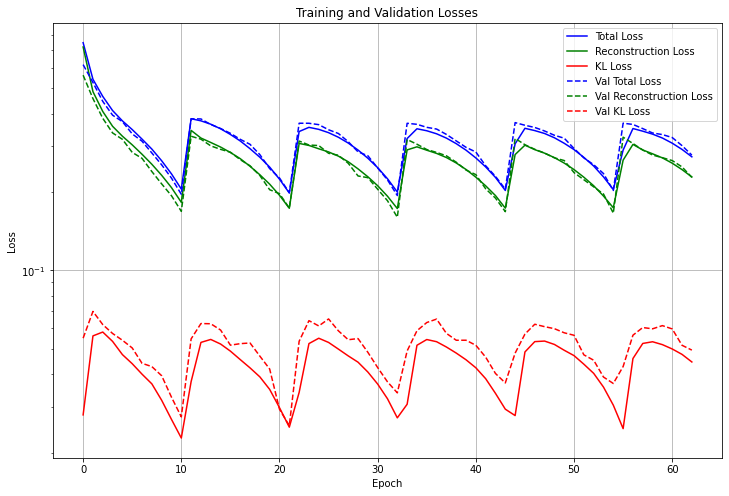

In [22]:
import matplotlib.pyplot as plt

# Extract the loss values
total_loss = history.history['loss']
reco_loss = history.history['reco_loss']
kl_loss = history.history['kl_loss']
val_total_loss = history.history['val_loss']
val_reco_loss = history.history['val_reco_loss']
val_kl_loss = history.history['val_kl_loss']

# Create a new figure
plt.figure(figsize=(12, 8))

# Plot training losses
plt.plot(total_loss, label='Total Loss', color='blue')
plt.plot(reco_loss, label='Reconstruction Loss', color='green')
plt.plot(kl_loss, label='KL Loss', color='red')

# Plot validation losses
plt.plot(val_total_loss, label='Val Total Loss', color='blue', linestyle='--')
plt.plot(val_reco_loss, label='Val Reconstruction Loss', color='green', linestyle='--')
plt.plot(val_kl_loss, label='Val KL Loss', color='red', linestyle='--')

# Customize the plot
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
# plt.ylim(1e-2,1)
plt.ylabel('Loss')
plt.yscale("log")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [15]:
for i in range(0,30):
    T2A_enc = Qmake_encoder_set_weights(Topo_2A.shape[1],32,16,3)
    T2A_dec = Qmake_decoder_set_weights(Topo_2A.shape[1],32,16,3)
    steps_per_epoch = Topo_2A_test_L1failed.shape[0] // BATCH_SIZE
    T2A = VAE_Model(T2A_enc, T2A_dec, steps_per_epoch=steps_per_epoch, min_beta=0.1, max_beta=0.7)
    # T2A.set_beta(beta)
    opt = keras.optimizers.Adam(learning_rate=0.001)
    T2A.compile(optimizer=opt,weighted_metrics=[weighted_mse]) #,weighted_metrics=[weighted_mse]

    early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=LR_PATIENCE, verbose=1)

    callbacks = [early_stopping, reduce_lr]

    tf.keras.backend.clear_session()
    history = T2A.fit(x=Topo_2A_test_L1failed, validation_split=0.1, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, shuffle=True)#, sample_weight=Topo_t_weights
    T2A.save_weights(filepath='/eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_{}/'.format(i), save_format='tf')

Epoch 1/100
320/320 [==============================] - 8s 10ms/step - loss: 0.9913 - reco_loss: 0.9735 - kl_loss: 0.0231 - beta: 0.1546 - val_loss: 0.6355 - val_reco_loss: 0.5919 - val_kl_loss: 0.0436 - val_beta: 0.1546 - lr: 0.0010
Epoch 2/100
320/320 [==============================] - 2s 5ms/step - loss: 0.5790 - reco_loss: 0.5332 - kl_loss: 0.0492 - beta: 0.2085 - val_loss: 0.5182 - val_reco_loss: 0.4621 - val_kl_loss: 0.0561 - val_beta: 0.2085 - lr: 0.0010
Epoch 3/100
320/320 [==============================] - 2s 5ms/step - loss: 0.4881 - reco_loss: 0.4338 - kl_loss: 0.0543 - beta: 0.2628 - val_loss: 0.4701 - val_reco_loss: 0.4104 - val_kl_loss: 0.0596 - val_beta: 0.2628 - lr: 0.0010
Epoch 4/100
320/320 [==============================] - 2s 5ms/step - loss: 0.4506 - reco_loss: 0.3978 - kl_loss: 0.0519 - beta: 0.3172 - val_loss: 0.4235 - val_reco_loss: 0.3687 - val_kl_loss: 0.0548 - val_beta: 0.3172 - lr: 0.0010
Epoch 5/100
320/320 [==============================] - 2s 5ms/step - lo

320/320 [==============================] - 2s 5ms/step - loss: 0.2583 - reco_loss: 0.2343 - kl_loss: 0.0304 - beta: 0.1387 - val_loss: 0.3627 - val_reco_loss: 0.3122 - val_kl_loss: 0.0505 - val_beta: 0.1387 - lr: 4.9000e-04
Epoch 35/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3563 - reco_loss: 0.3088 - kl_loss: 0.0495 - beta: 0.1929 - val_loss: 0.3487 - val_reco_loss: 0.2888 - val_kl_loss: 0.0599 - val_beta: 0.1929 - lr: 4.9000e-04
Epoch 36/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3485 - reco_loss: 0.2948 - kl_loss: 0.0539 - beta: 0.2471 - val_loss: 0.3402 - val_reco_loss: 0.2766 - val_kl_loss: 0.0636 - val_beta: 0.2471 - lr: 4.9000e-04
Epoch 37/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3359 - reco_loss: 0.2819 - kl_loss: 0.0537 - beta: 0.3014 - val_loss: 0.3416 - val_reco_loss: 0.2846 - val_kl_loss: 0.0570 - val_beta: 0.3014 - lr: 4.9000e-04
Epoch 38/100
320/320 [==============================] - 2s 5ms/st

320/320 [==============================] - 2s 5ms/step - loss: 0.2116 - reco_loss: 0.1796 - kl_loss: 0.0313 - beta: 0.6696 - val_loss: 0.1981 - val_reco_loss: 0.1609 - val_kl_loss: 0.0372 - val_beta: 0.6696 - lr: 1.6807e-04
Epoch 67/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2144 - reco_loss: 0.1877 - kl_loss: 0.0243 - beta: 0.1235 - val_loss: 0.3667 - val_reco_loss: 0.3309 - val_kl_loss: 0.0358 - val_beta: 0.1235 - lr: 1.6807e-04
Epoch 68/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3546 - reco_loss: 0.3152 - kl_loss: 0.0431 - beta: 0.1776 - val_loss: 0.3507 - val_reco_loss: 0.3019 - val_kl_loss: 0.0487 - val_beta: 0.1776 - lr: 1.6807e-04
Epoch 69/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3442 - reco_loss: 0.2953 - kl_loss: 0.0503 - beta: 0.2317 - val_loss: 0.3452 - val_reco_loss: 0.2849 - val_kl_loss: 0.0602 - val_beta: 0.2317 - lr: 1.6807e-04
Epoch 70/100
320/320 [==============================] - 2s 5ms/st

320/320 [==============================] - 2s 5ms/step - loss: 0.3476 - reco_loss: 0.2924 - kl_loss: 0.0550 - beta: 0.2523 - val_loss: 0.3394 - val_reco_loss: 0.2801 - val_kl_loss: 0.0592 - val_beta: 0.2523 - lr: 7.0000e-04
Epoch 26/100
320/320 [==============================] - 2s 6ms/step - loss: 0.3377 - reco_loss: 0.2836 - kl_loss: 0.0537 - beta: 0.3066 - val_loss: 0.3273 - val_reco_loss: 0.2646 - val_kl_loss: 0.0627 - val_beta: 0.3066 - lr: 7.0000e-04
Epoch 27/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3278 - reco_loss: 0.2759 - kl_loss: 0.0507 - beta: 0.3608 - val_loss: 0.3263 - val_reco_loss: 0.2642 - val_kl_loss: 0.0620 - val_beta: 0.3608 - lr: 7.0000e-04
Epoch 28/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3109 - reco_loss: 0.2618 - kl_loss: 0.0481 - beta: 0.4150 - val_loss: 0.3006 - val_reco_loss: 0.2505 - val_kl_loss: 0.0501 - val_beta: 0.4150 - lr: 7.0000e-04
Epoch 29/100
320/320 [==============================] - 2s 5ms/st

320/320 [==============================] - 2s 5ms/step - loss: 0.3888 - reco_loss: 0.3409 - kl_loss: 0.0463 - beta: 0.3713 - val_loss: 0.3407 - val_reco_loss: 0.2897 - val_kl_loss: 0.0510 - val_beta: 0.3713 - lr: 0.0010
Epoch 6/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3636 - reco_loss: 0.3200 - kl_loss: 0.0427 - beta: 0.4252 - val_loss: 0.3275 - val_reco_loss: 0.2829 - val_kl_loss: 0.0447 - val_beta: 0.4252 - lr: 0.0010
Epoch 7/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3349 - reco_loss: 0.2953 - kl_loss: 0.0389 - beta: 0.4794 - val_loss: 0.3006 - val_reco_loss: 0.2569 - val_kl_loss: 0.0437 - val_beta: 0.4794 - lr: 0.0010
Epoch 8/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3097 - reco_loss: 0.2740 - kl_loss: 0.0345 - beta: 0.5336 - val_loss: 0.2691 - val_reco_loss: 0.2268 - val_kl_loss: 0.0424 - val_beta: 0.5336 - lr: 0.0010
Epoch 9/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2817 - 

320/320 [==============================] - 2s 5ms/step - loss: 0.3290 - reco_loss: 0.2772 - kl_loss: 0.0513 - beta: 0.3555 - val_loss: 0.3139 - val_reco_loss: 0.2559 - val_kl_loss: 0.0580 - val_beta: 0.3555 - lr: 4.9000e-04
Epoch 39/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3132 - reco_loss: 0.2647 - kl_loss: 0.0476 - beta: 0.4097 - val_loss: 0.3045 - val_reco_loss: 0.2475 - val_kl_loss: 0.0570 - val_beta: 0.4097 - lr: 4.9000e-04
Epoch 40/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2964 - reco_loss: 0.2509 - kl_loss: 0.0444 - beta: 0.4638 - val_loss: 0.2838 - val_reco_loss: 0.2313 - val_kl_loss: 0.0525 - val_beta: 0.4638 - lr: 4.9000e-04
Epoch 41/100
317/320 [============================>.] - ETA: 0s - loss: 0.2766 - reco_loss: 0.2346 - kl_loss: 0.0411 - beta: 0.5174
Epoch 41: ReduceLROnPlateau reducing learning rate to 0.00034300000406801696.
320/320 [==============================] - 2s 5ms/step - loss: 0.2766 - reco_loss: 0.2345 - 

320/320 [==============================] - 2s 5ms/step - loss: 0.2821 - reco_loss: 0.2407 - kl_loss: 0.0402 - beta: 0.5232 - val_loss: 0.2733 - val_reco_loss: 0.2251 - val_kl_loss: 0.0483 - val_beta: 0.5232 - lr: 7.0000e-04
Epoch 31/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2593 - reco_loss: 0.2217 - kl_loss: 0.0364 - beta: 0.5773 - val_loss: 0.2530 - val_reco_loss: 0.2076 - val_kl_loss: 0.0453 - val_beta: 0.5773 - lr: 7.0000e-04
Epoch 32/100
312/320 [============================>.] - ETA: 0s - loss: 0.2326 - reco_loss: 0.2001 - kl_loss: 0.0315 - beta: 0.6300
Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0004900000232737511.
320/320 [==============================] - 2s 5ms/step - loss: 0.2325 - reco_loss: 0.2000 - kl_loss: 0.0315 - beta: 0.6314 - val_loss: 0.2267 - val_reco_loss: 0.1905 - val_kl_loss: 0.0362 - val_beta: 0.6314 - lr: 7.0000e-04
Epoch 33/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2089 - reco_loss: 0.1814 - k

320/320 [==============================] - 2s 5ms/step - loss: 0.2406 - reco_loss: 0.2126 - kl_loss: 0.0267 - beta: 0.6417 - val_loss: 0.2278 - val_reco_loss: 0.1977 - val_kl_loss: 0.0302 - val_beta: 0.6417 - lr: 0.0010
Epoch 11/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2093 - reco_loss: 0.1868 - kl_loss: 0.0217 - beta: 0.6958 - val_loss: 0.1961 - val_reco_loss: 0.1708 - val_kl_loss: 0.0253 - val_beta: 0.6958 - lr: 0.0010
Epoch 12/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3523 - reco_loss: 0.3278 - kl_loss: 0.0359 - beta: 0.1490 - val_loss: 0.3997 - val_reco_loss: 0.3492 - val_kl_loss: 0.0506 - val_beta: 0.1490 - lr: 0.0010
Epoch 13/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3874 - reco_loss: 0.3365 - kl_loss: 0.0523 - beta: 0.2033 - val_loss: 0.3843 - val_reco_loss: 0.3286 - val_kl_loss: 0.0558 - val_beta: 0.2033 - lr: 0.0010
Epoch 14/100
320/320 [==============================] - 2s 5ms/step - loss: 0.367

320/320 [==============================] - 8s 11ms/step - loss: 0.9244 - reco_loss: 0.9007 - kl_loss: 0.0344 - beta: 0.1545 - val_loss: 0.6155 - val_reco_loss: 0.5662 - val_kl_loss: 0.0492 - val_beta: 0.1545 - lr: 0.0010
Epoch 2/100
320/320 [==============================] - 2s 5ms/step - loss: 0.5856 - reco_loss: 0.5357 - kl_loss: 0.0517 - beta: 0.2086 - val_loss: 0.5009 - val_reco_loss: 0.4421 - val_kl_loss: 0.0588 - val_beta: 0.2086 - lr: 0.0010
Epoch 3/100
320/320 [==============================] - 2s 5ms/step - loss: 0.4795 - reco_loss: 0.4255 - kl_loss: 0.0539 - beta: 0.2628 - val_loss: 0.4408 - val_reco_loss: 0.3799 - val_kl_loss: 0.0609 - val_beta: 0.2628 - lr: 0.0010
Epoch 4/100
320/320 [==============================] - 2s 5ms/step - loss: 0.4272 - reco_loss: 0.3747 - kl_loss: 0.0513 - beta: 0.3171 - val_loss: 0.4002 - val_reco_loss: 0.3491 - val_kl_loss: 0.0511 - val_beta: 0.3171 - lr: 0.0010
Epoch 5/100
320/320 [==============================] - 2s 5ms/step - loss: 0.4063 -

320/320 [==============================] - 2s 5ms/step - loss: 0.2630 - reco_loss: 0.2389 - kl_loss: 0.0304 - beta: 0.1387 - val_loss: 0.3517 - val_reco_loss: 0.3008 - val_kl_loss: 0.0508 - val_beta: 0.1387 - lr: 4.9000e-04
Epoch 35/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3576 - reco_loss: 0.3088 - kl_loss: 0.0506 - beta: 0.1929 - val_loss: 0.3499 - val_reco_loss: 0.2905 - val_kl_loss: 0.0595 - val_beta: 0.1929 - lr: 4.9000e-04
Epoch 36/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3466 - reco_loss: 0.2930 - kl_loss: 0.0541 - beta: 0.2472 - val_loss: 0.3453 - val_reco_loss: 0.2853 - val_kl_loss: 0.0600 - val_beta: 0.2472 - lr: 4.9000e-04
Epoch 37/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3403 - reco_loss: 0.2861 - kl_loss: 0.0538 - beta: 0.3014 - val_loss: 0.3300 - val_reco_loss: 0.2708 - val_kl_loss: 0.0592 - val_beta: 0.3014 - lr: 4.9000e-04
Epoch 38/100
320/320 [==============================] - 2s 5ms/st

320/320 [==============================] - 2s 5ms/step - loss: 0.3458 - reco_loss: 0.2913 - kl_loss: 0.0535 - beta: 0.3066 - val_loss: 0.3411 - val_reco_loss: 0.2800 - val_kl_loss: 0.0611 - val_beta: 0.3066 - lr: 7.0000e-04
Epoch 27/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3292 - reco_loss: 0.2785 - kl_loss: 0.0499 - beta: 0.3608 - val_loss: 0.3351 - val_reco_loss: 0.2789 - val_kl_loss: 0.0562 - val_beta: 0.3608 - lr: 7.0000e-04
Epoch 28/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3128 - reco_loss: 0.2652 - kl_loss: 0.0469 - beta: 0.4150 - val_loss: 0.3120 - val_reco_loss: 0.2631 - val_kl_loss: 0.0489 - val_beta: 0.4150 - lr: 7.0000e-04
Epoch 29/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2999 - reco_loss: 0.2545 - kl_loss: 0.0441 - beta: 0.4691 - val_loss: 0.2935 - val_reco_loss: 0.2444 - val_kl_loss: 0.0491 - val_beta: 0.4691 - lr: 7.0000e-04
Epoch 30/100
320/320 [==============================] - 2s 5ms/st

320/320 [==============================] - 2s 5ms/step - loss: 0.3439 - reco_loss: 0.2908 - kl_loss: 0.0540 - beta: 0.2369 - val_loss: 0.3539 - val_reco_loss: 0.2942 - val_kl_loss: 0.0597 - val_beta: 0.2369 - lr: 2.4010e-04
Epoch 59/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3382 - reco_loss: 0.2830 - kl_loss: 0.0545 - beta: 0.2910 - val_loss: 0.3412 - val_reco_loss: 0.2797 - val_kl_loss: 0.0615 - val_beta: 0.2910 - lr: 2.4010e-04
Epoch 60/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3248 - reco_loss: 0.2724 - kl_loss: 0.0519 - beta: 0.3451 - val_loss: 0.3346 - val_reco_loss: 0.2756 - val_kl_loss: 0.0590 - val_beta: 0.3451 - lr: 2.4010e-04
Epoch 61/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3142 - reco_loss: 0.2643 - kl_loss: 0.0490 - beta: 0.3993 - val_loss: 0.3271 - val_reco_loss: 0.2726 - val_kl_loss: 0.0545 - val_beta: 0.3993 - lr: 2.4010e-04
Epoch 62/100
320/320 [==============================] - 2s 5ms/st

320/320 [==============================] - 2s 5ms/step - loss: 0.3149 - reco_loss: 0.2663 - kl_loss: 0.0476 - beta: 0.4150 - val_loss: 0.3042 - val_reco_loss: 0.2492 - val_kl_loss: 0.0549 - val_beta: 0.4150 - lr: 7.0000e-04
Epoch 29/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2929 - reco_loss: 0.2478 - kl_loss: 0.0449 - beta: 0.4691 - val_loss: 0.2886 - val_reco_loss: 0.2359 - val_kl_loss: 0.0527 - val_beta: 0.4691 - lr: 7.0000e-04
Epoch 30/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2739 - reco_loss: 0.2313 - kl_loss: 0.0417 - beta: 0.5232 - val_loss: 0.2785 - val_reco_loss: 0.2320 - val_kl_loss: 0.0465 - val_beta: 0.5232 - lr: 7.0000e-04
Epoch 31/100
314/320 [============================>.] - ETA: 0s - loss: 0.2535 - reco_loss: 0.2160 - kl_loss: 0.0368 - beta: 0.5763
Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0004900000232737511.
320/320 [==============================] - 2s 5ms/step - loss: 0.2534 - reco_loss: 0.2159 - k

320/320 [==============================] - 2s 5ms/step - loss: 0.3293 - reco_loss: 0.2759 - kl_loss: 0.0526 - beta: 0.3451 - val_loss: 0.3224 - val_reco_loss: 0.2582 - val_kl_loss: 0.0642 - val_beta: 0.3451 - lr: 2.4010e-04
Epoch 61/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3117 - reco_loss: 0.2604 - kl_loss: 0.0506 - beta: 0.3993 - val_loss: 0.3014 - val_reco_loss: 0.2435 - val_kl_loss: 0.0579 - val_beta: 0.3993 - lr: 2.4010e-04
Epoch 62/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2941 - reco_loss: 0.2457 - kl_loss: 0.0478 - beta: 0.4534 - val_loss: 0.2990 - val_reco_loss: 0.2456 - val_kl_loss: 0.0534 - val_beta: 0.4534 - lr: 2.4010e-04
Epoch 63/100
317/320 [============================>.] - ETA: 0s - loss: 0.2778 - reco_loss: 0.2322 - kl_loss: 0.0455 - beta: 0.5069
Epoch 63: ReduceLROnPlateau reducing learning rate to 0.00016806999628897755.
320/320 [==============================] - 2s 5ms/step - loss: 0.2778 - reco_loss: 0.2321 - 

320/320 [==============================] - 2s 5ms/step - loss: 0.2754 - reco_loss: 0.2344 - kl_loss: 0.0401 - beta: 0.5232 - val_loss: 0.2739 - val_reco_loss: 0.2287 - val_kl_loss: 0.0452 - val_beta: 0.5232 - lr: 7.0000e-04
Epoch 31/100
318/320 [============================>.] - ETA: 0s - loss: 0.2519 - reco_loss: 0.2153 - kl_loss: 0.0358 - beta: 0.5770
Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0004900000232737511.
320/320 [==============================] - 2s 5ms/step - loss: 0.2519 - reco_loss: 0.2152 - kl_loss: 0.0358 - beta: 0.5773 - val_loss: 0.2497 - val_reco_loss: 0.2077 - val_kl_loss: 0.0420 - val_beta: 0.5773 - lr: 7.0000e-04
Epoch 32/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2298 - reco_loss: 0.1972 - kl_loss: 0.0313 - beta: 0.6311 - val_loss: 0.2239 - val_reco_loss: 0.1870 - val_kl_loss: 0.0369 - val_beta: 0.6311 - lr: 4.9000e-04
Epoch 33/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2040 - reco_loss: 0.1763 - k

Epoch 22/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2077 - reco_loss: 0.1816 - kl_loss: 0.0246 - beta: 0.6905 - val_loss: 0.1933 - val_reco_loss: 0.1653 - val_kl_loss: 0.0280 - val_beta: 0.6905 - lr: 7.0000e-04
Epoch 23/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2905 - reco_loss: 0.2652 - kl_loss: 0.0340 - beta: 0.1438 - val_loss: 0.3772 - val_reco_loss: 0.3235 - val_kl_loss: 0.0538 - val_beta: 0.1438 - lr: 7.0000e-04
Epoch 24/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3555 - reco_loss: 0.3049 - kl_loss: 0.0520 - beta: 0.1981 - val_loss: 0.3682 - val_reco_loss: 0.3074 - val_kl_loss: 0.0608 - val_beta: 0.1981 - lr: 7.0000e-04
Epoch 25/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3493 - reco_loss: 0.2944 - kl_loss: 0.0550 - beta: 0.2523 - val_loss: 0.3548 - val_reco_loss: 0.2971 - val_kl_loss: 0.0578 - val_beta: 0.2523 - lr: 7.0000e-04
Epoch 26/100
320/320 [==============================

320/320 [==============================] - 2s 5ms/step - loss: 0.5811 - reco_loss: 0.5389 - kl_loss: 0.0439 - beta: 0.2086 - val_loss: 0.5102 - val_reco_loss: 0.4589 - val_kl_loss: 0.0513 - val_beta: 0.2086 - lr: 0.0010
Epoch 3/100
320/320 [==============================] - 2s 5ms/step - loss: 0.5091 - reco_loss: 0.4607 - kl_loss: 0.0492 - beta: 0.2628 - val_loss: 0.4360 - val_reco_loss: 0.3826 - val_kl_loss: 0.0534 - val_beta: 0.2628 - lr: 0.0010
Epoch 4/100
320/320 [==============================] - 2s 5ms/step - loss: 0.4439 - reco_loss: 0.3940 - kl_loss: 0.0497 - beta: 0.3169 - val_loss: 0.3851 - val_reco_loss: 0.3294 - val_kl_loss: 0.0557 - val_beta: 0.3169 - lr: 0.0010
Epoch 5/100
320/320 [==============================] - 2s 5ms/step - loss: 0.4043 - reco_loss: 0.3573 - kl_loss: 0.0460 - beta: 0.3712 - val_loss: 0.3723 - val_reco_loss: 0.3200 - val_kl_loss: 0.0522 - val_beta: 0.3712 - lr: 0.0010
Epoch 6/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3621 - 

320/320 [==============================] - 2s 5ms/step - loss: 0.3522 - reco_loss: 0.3044 - kl_loss: 0.0502 - beta: 0.1929 - val_loss: 0.3427 - val_reco_loss: 0.2859 - val_kl_loss: 0.0568 - val_beta: 0.1929 - lr: 4.9000e-04
Epoch 36/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3463 - reco_loss: 0.2933 - kl_loss: 0.0532 - beta: 0.2472 - val_loss: 0.3382 - val_reco_loss: 0.2726 - val_kl_loss: 0.0655 - val_beta: 0.2472 - lr: 4.9000e-04
Epoch 37/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3387 - reco_loss: 0.2857 - kl_loss: 0.0527 - beta: 0.3014 - val_loss: 0.3338 - val_reco_loss: 0.2751 - val_kl_loss: 0.0587 - val_beta: 0.3014 - lr: 4.9000e-04
Epoch 38/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3260 - reco_loss: 0.2750 - kl_loss: 0.0503 - beta: 0.3556 - val_loss: 0.3192 - val_reco_loss: 0.2572 - val_kl_loss: 0.0620 - val_beta: 0.3556 - lr: 4.9000e-04
Epoch 39/100
320/320 [==============================] - 2s 5ms/st

320/320 [==============================] - 2s 5ms/step - loss: 0.3256 - reco_loss: 0.2747 - kl_loss: 0.0501 - beta: 0.3608 - val_loss: 0.3188 - val_reco_loss: 0.2622 - val_kl_loss: 0.0566 - val_beta: 0.3608 - lr: 7.0000e-04
Epoch 28/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3108 - reco_loss: 0.2630 - kl_loss: 0.0471 - beta: 0.4150 - val_loss: 0.3086 - val_reco_loss: 0.2617 - val_kl_loss: 0.0469 - val_beta: 0.4150 - lr: 7.0000e-04
Epoch 29/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2935 - reco_loss: 0.2489 - kl_loss: 0.0438 - beta: 0.4691 - val_loss: 0.2883 - val_reco_loss: 0.2441 - val_kl_loss: 0.0442 - val_beta: 0.4691 - lr: 7.0000e-04
Epoch 30/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2749 - reco_loss: 0.2337 - kl_loss: 0.0406 - beta: 0.5232 - val_loss: 0.2748 - val_reco_loss: 0.2274 - val_kl_loss: 0.0474 - val_beta: 0.5232 - lr: 7.0000e-04
Epoch 31/100
320/320 [==============================] - 2s 5ms/st

320/320 [==============================] - 2s 5ms/step - loss: 0.3266 - reco_loss: 0.2855 - kl_loss: 0.0407 - beta: 0.4795 - val_loss: 0.3125 - val_reco_loss: 0.2646 - val_kl_loss: 0.0479 - val_beta: 0.4795 - lr: 0.0010
Epoch 8/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3015 - reco_loss: 0.2648 - kl_loss: 0.0360 - beta: 0.5335 - val_loss: 0.2866 - val_reco_loss: 0.2433 - val_kl_loss: 0.0432 - val_beta: 0.5335 - lr: 0.0010
Epoch 9/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2726 - reco_loss: 0.2398 - kl_loss: 0.0319 - beta: 0.5876 - val_loss: 0.2535 - val_reco_loss: 0.2145 - val_kl_loss: 0.0390 - val_beta: 0.5876 - lr: 0.0010
Epoch 10/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2406 - reco_loss: 0.2119 - kl_loss: 0.0277 - beta: 0.6418 - val_loss: 0.2217 - val_reco_loss: 0.1871 - val_kl_loss: 0.0346 - val_beta: 0.6418 - lr: 0.0010
Epoch 11/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2138 

320/320 [==============================] - 2s 5ms/step - loss: 0.2912 - reco_loss: 0.2450 - kl_loss: 0.0461 - beta: 0.4638 - val_loss: 0.2966 - val_reco_loss: 0.2454 - val_kl_loss: 0.0512 - val_beta: 0.4638 - lr: 4.9000e-04
Epoch 41/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2757 - reco_loss: 0.2326 - kl_loss: 0.0420 - beta: 0.5179 - val_loss: 0.2708 - val_reco_loss: 0.2224 - val_kl_loss: 0.0484 - val_beta: 0.5179 - lr: 4.9000e-04
Epoch 42/100
319/320 [============================>.] - ETA: 0s - loss: 0.2549 - reco_loss: 0.2163 - kl_loss: 0.0375 - beta: 0.5718
Epoch 42: ReduceLROnPlateau reducing learning rate to 0.00034300000406801696.
320/320 [==============================] - 2s 5ms/step - loss: 0.2548 - reco_loss: 0.2162 - kl_loss: 0.0375 - beta: 0.5720 - val_loss: 0.2574 - val_reco_loss: 0.2180 - val_kl_loss: 0.0394 - val_beta: 0.5720 - lr: 4.9000e-04
Epoch 43/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2318 - reco_loss: 0.1974 - 

315/320 [============================>.] - ETA: 0s - loss: 0.2333 - reco_loss: 0.2030 - kl_loss: 0.0291 - beta: 0.6360
Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
320/320 [==============================] - 2s 5ms/step - loss: 0.2332 - reco_loss: 0.2029 - kl_loss: 0.0291 - beta: 0.6368 - val_loss: 0.2175 - val_reco_loss: 0.1864 - val_kl_loss: 0.0310 - val_beta: 0.6368 - lr: 0.0010
Epoch 22/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2074 - reco_loss: 0.1818 - kl_loss: 0.0245 - beta: 0.6905 - val_loss: 0.1947 - val_reco_loss: 0.1639 - val_kl_loss: 0.0308 - val_beta: 0.6905 - lr: 7.0000e-04
Epoch 23/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2939 - reco_loss: 0.2694 - kl_loss: 0.0329 - beta: 0.1438 - val_loss: 0.3614 - val_reco_loss: 0.3065 - val_kl_loss: 0.0549 - val_beta: 0.1438 - lr: 7.0000e-04
Epoch 24/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3619 - reco_loss: 0.3117 - kl_lo

317/320 [============================>.] - ETA: 0s - loss: 0.2541 - reco_loss: 0.2153 - kl_loss: 0.0380 - beta: 0.5662
Epoch 53: ReduceLROnPlateau reducing learning rate to 0.00024009999469853935.
320/320 [==============================] - 2s 5ms/step - loss: 0.2540 - reco_loss: 0.2153 - kl_loss: 0.0380 - beta: 0.5667 - val_loss: 0.2541 - val_reco_loss: 0.2189 - val_kl_loss: 0.0352 - val_beta: 0.5667 - lr: 3.4300e-04
Epoch 54/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2349 - reco_loss: 0.2001 - kl_loss: 0.0337 - beta: 0.6207 - val_loss: 0.2279 - val_reco_loss: 0.1921 - val_kl_loss: 0.0358 - val_beta: 0.6207 - lr: 2.4010e-04
Epoch 55/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2097 - reco_loss: 0.1798 - kl_loss: 0.0290 - beta: 0.6748 - val_loss: 0.1986 - val_reco_loss: 0.1684 - val_kl_loss: 0.0301 - val_beta: 0.6748 - lr: 2.4010e-04
Epoch 56/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2228 - reco_loss: 0.1983 - 

320/320 [==============================] - 2s 5ms/step - loss: 0.2051 - reco_loss: 0.1783 - kl_loss: 0.0257 - beta: 0.6905 - val_loss: 0.1959 - val_reco_loss: 0.1687 - val_kl_loss: 0.0272 - val_beta: 0.6905 - lr: 7.0000e-04
Epoch 23/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2897 - reco_loss: 0.2649 - kl_loss: 0.0329 - beta: 0.1438 - val_loss: 0.3608 - val_reco_loss: 0.3091 - val_kl_loss: 0.0517 - val_beta: 0.1438 - lr: 7.0000e-04
Epoch 24/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3548 - reco_loss: 0.3059 - kl_loss: 0.0506 - beta: 0.1981 - val_loss: 0.3503 - val_reco_loss: 0.2899 - val_kl_loss: 0.0605 - val_beta: 0.1981 - lr: 7.0000e-04
Epoch 25/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3498 - reco_loss: 0.2967 - kl_loss: 0.0533 - beta: 0.2524 - val_loss: 0.3459 - val_reco_loss: 0.2892 - val_kl_loss: 0.0567 - val_beta: 0.2524 - lr: 7.0000e-04
Epoch 26/100
320/320 [==============================] - 2s 5ms/st

320/320 [==============================] - 2s 5ms/step - loss: 0.3654 - reco_loss: 0.3120 - kl_loss: 0.0534 - beta: 0.2577 - val_loss: 0.3710 - val_reco_loss: 0.3163 - val_kl_loss: 0.0547 - val_beta: 0.2577 - lr: 0.0010
Epoch 15/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3503 - reco_loss: 0.2976 - kl_loss: 0.0521 - beta: 0.3120 - val_loss: 0.3415 - val_reco_loss: 0.2801 - val_kl_loss: 0.0614 - val_beta: 0.3120 - lr: 0.0010
Epoch 16/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3325 - reco_loss: 0.2826 - kl_loss: 0.0498 - beta: 0.3662 - val_loss: 0.3264 - val_reco_loss: 0.2643 - val_kl_loss: 0.0621 - val_beta: 0.3662 - lr: 0.0010
Epoch 17/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3176 - reco_loss: 0.2698 - kl_loss: 0.0464 - beta: 0.4204 - val_loss: 0.3123 - val_reco_loss: 0.2565 - val_kl_loss: 0.0558 - val_beta: 0.4204 - lr: 0.0010
Epoch 18/100
320/320 [==============================] - 2s 5ms/step - loss: 0.296

320/320 [==============================] - 2s 5ms/step - loss: 0.3496 - reco_loss: 0.3033 - kl_loss: 0.0482 - beta: 0.1878 - val_loss: 0.3606 - val_reco_loss: 0.3050 - val_kl_loss: 0.0556 - val_beta: 0.1878 - lr: 3.4300e-04
Epoch 47/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3447 - reco_loss: 0.2926 - kl_loss: 0.0528 - beta: 0.2420 - val_loss: 0.3482 - val_reco_loss: 0.2881 - val_kl_loss: 0.0602 - val_beta: 0.2420 - lr: 3.4300e-04
Epoch 48/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3345 - reco_loss: 0.2813 - kl_loss: 0.0531 - beta: 0.2962 - val_loss: 0.3437 - val_reco_loss: 0.2802 - val_kl_loss: 0.0636 - val_beta: 0.2962 - lr: 3.4300e-04
Epoch 49/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3260 - reco_loss: 0.2740 - kl_loss: 0.0513 - beta: 0.3503 - val_loss: 0.3364 - val_reco_loss: 0.2756 - val_kl_loss: 0.0607 - val_beta: 0.3503 - lr: 3.4300e-04
Epoch 50/100
320/320 [==============================] - 2s 5ms/st

320/320 [==============================] - 2s 5ms/step - loss: 0.3355 - reco_loss: 0.2861 - kl_loss: 0.0487 - beta: 0.3662 - val_loss: 0.3388 - val_reco_loss: 0.2809 - val_kl_loss: 0.0579 - val_beta: 0.3662 - lr: 0.0010
Epoch 17/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3178 - reco_loss: 0.2706 - kl_loss: 0.0463 - beta: 0.4203 - val_loss: 0.3157 - val_reco_loss: 0.2606 - val_kl_loss: 0.0551 - val_beta: 0.4203 - lr: 0.0010
Epoch 18/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2961 - reco_loss: 0.2526 - kl_loss: 0.0430 - beta: 0.4745 - val_loss: 0.3045 - val_reco_loss: 0.2533 - val_kl_loss: 0.0511 - val_beta: 0.4745 - lr: 0.0010
Epoch 19/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2787 - reco_loss: 0.2390 - kl_loss: 0.0389 - beta: 0.5286 - val_loss: 0.2792 - val_reco_loss: 0.2372 - val_kl_loss: 0.0421 - val_beta: 0.5286 - lr: 0.0010
Epoch 20/100
320/320 [==============================] - 2s 5ms/step - loss: 0.255

320/320 [==============================] - 2s 5ms/step - loss: 0.3370 - reco_loss: 0.2829 - kl_loss: 0.0538 - beta: 0.2962 - val_loss: 0.3402 - val_reco_loss: 0.2771 - val_kl_loss: 0.0631 - val_beta: 0.2962 - lr: 3.4300e-04
Epoch 49/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3258 - reco_loss: 0.2730 - kl_loss: 0.0516 - beta: 0.3503 - val_loss: 0.3329 - val_reco_loss: 0.2728 - val_kl_loss: 0.0601 - val_beta: 0.3503 - lr: 3.4300e-04
Epoch 50/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3118 - reco_loss: 0.2620 - kl_loss: 0.0492 - beta: 0.4044 - val_loss: 0.3190 - val_reco_loss: 0.2658 - val_kl_loss: 0.0532 - val_beta: 0.4044 - lr: 3.4300e-04
Epoch 51/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2946 - reco_loss: 0.2483 - kl_loss: 0.0460 - beta: 0.4586 - val_loss: 0.2946 - val_reco_loss: 0.2426 - val_kl_loss: 0.0520 - val_beta: 0.4586 - lr: 3.4300e-04
Epoch 52/100
320/320 [==============================] - 2s 5ms/st

320/320 [==============================] - 2s 5ms/step - loss: 0.3616 - reco_loss: 0.3172 - kl_loss: 0.0439 - beta: 0.4253 - val_loss: 0.3322 - val_reco_loss: 0.2875 - val_kl_loss: 0.0447 - val_beta: 0.4253 - lr: 0.0010
Epoch 7/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3279 - reco_loss: 0.2881 - kl_loss: 0.0394 - beta: 0.4794 - val_loss: 0.3032 - val_reco_loss: 0.2589 - val_kl_loss: 0.0443 - val_beta: 0.4794 - lr: 0.0010
Epoch 8/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3017 - reco_loss: 0.2644 - kl_loss: 0.0359 - beta: 0.5335 - val_loss: 0.2835 - val_reco_loss: 0.2438 - val_kl_loss: 0.0397 - val_beta: 0.5335 - lr: 0.0010
Epoch 9/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2760 - reco_loss: 0.2434 - kl_loss: 0.0313 - beta: 0.5876 - val_loss: 0.2479 - val_reco_loss: 0.2150 - val_kl_loss: 0.0329 - val_beta: 0.5876 - lr: 0.0010
Epoch 10/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2392 -

320/320 [==============================] - 2s 5ms/step - loss: 0.3146 - reco_loss: 0.2653 - kl_loss: 0.0486 - beta: 0.4097 - val_loss: 0.3127 - val_reco_loss: 0.2628 - val_kl_loss: 0.0500 - val_beta: 0.4097 - lr: 4.9000e-04
Epoch 40/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2969 - reco_loss: 0.2506 - kl_loss: 0.0450 - beta: 0.4638 - val_loss: 0.2931 - val_reco_loss: 0.2381 - val_kl_loss: 0.0550 - val_beta: 0.4638 - lr: 4.9000e-04
Epoch 41/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2749 - reco_loss: 0.2321 - kl_loss: 0.0418 - beta: 0.5179 - val_loss: 0.2744 - val_reco_loss: 0.2289 - val_kl_loss: 0.0456 - val_beta: 0.5179 - lr: 4.9000e-04
Epoch 42/100
320/320 [==============================] - ETA: 0s - loss: 0.2560 - reco_loss: 0.2171 - kl_loss: 0.0379 - beta: 0.5720
Epoch 42: ReduceLROnPlateau reducing learning rate to 0.00034300000406801696.
320/320 [==============================] - 2s 5ms/step - loss: 0.2560 - reco_loss: 0.2171 - 

320/320 [==============================] - 2s 5ms/step - loss: 0.2606 - reco_loss: 0.2256 - kl_loss: 0.0340 - beta: 0.5826 - val_loss: 0.2468 - val_reco_loss: 0.2079 - val_kl_loss: 0.0388 - val_beta: 0.5826 - lr: 0.0010
Epoch 21/100
320/320 [==============================] - ETA: 0s - loss: 0.2364 - reco_loss: 0.2060 - kl_loss: 0.0295 - beta: 0.6367
Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
320/320 [==============================] - 2s 5ms/step - loss: 0.2364 - reco_loss: 0.2060 - kl_loss: 0.0295 - beta: 0.6367 - val_loss: 0.2271 - val_reco_loss: 0.1924 - val_kl_loss: 0.0347 - val_beta: 0.6367 - lr: 0.0010
Epoch 22/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2102 - reco_loss: 0.1841 - kl_loss: 0.0247 - beta: 0.6905 - val_loss: 0.1880 - val_reco_loss: 0.1560 - val_kl_loss: 0.0321 - val_beta: 0.6905 - lr: 7.0000e-04
Epoch 23/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3015 - reco_loss: 0.2771 - kl_loss: 

319/320 [============================>.] - ETA: 0s - loss: 0.2752 - reco_loss: 0.2318 - kl_loss: 0.0426 - beta: 0.5125
Epoch 52: ReduceLROnPlateau reducing learning rate to 0.00024009999469853935.
320/320 [==============================] - 2s 5ms/step - loss: 0.2751 - reco_loss: 0.2318 - kl_loss: 0.0426 - beta: 0.5126 - val_loss: 0.2768 - val_reco_loss: 0.2266 - val_kl_loss: 0.0501 - val_beta: 0.5126 - lr: 3.4300e-04
Epoch 1/100
320/320 [==============================] - 8s 12ms/step - loss: 0.9923 - reco_loss: 0.9804 - kl_loss: 0.0167 - beta: 0.1547 - val_loss: 0.6361 - val_reco_loss: 0.6078 - val_kl_loss: 0.0283 - val_beta: 0.1547 - lr: 0.0010
Epoch 2/100
320/320 [==============================] - 2s 5ms/step - loss: 0.5896 - reco_loss: 0.5571 - kl_loss: 0.0356 - beta: 0.2087 - val_loss: 0.5648 - val_reco_loss: 0.5206 - val_kl_loss: 0.0442 - val_beta: 0.2087 - lr: 0.0010
Epoch 3/100
320/320 [==============================] - 2s 5ms/step - loss: 0.5078 - reco_loss: 0.4650 - kl_loss: 0

Epoch 33/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2083 - reco_loss: 0.1804 - kl_loss: 0.0266 - beta: 0.6852 - val_loss: 0.1971 - val_reco_loss: 0.1619 - val_kl_loss: 0.0352 - val_beta: 0.6852 - lr: 4.9000e-04
Epoch 34/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2609 - reco_loss: 0.2382 - kl_loss: 0.0277 - beta: 0.1388 - val_loss: 0.3737 - val_reco_loss: 0.3273 - val_kl_loss: 0.0464 - val_beta: 0.1388 - lr: 4.9000e-04
Epoch 35/100
320/320 [==============================] - 2s 6ms/step - loss: 0.3584 - reco_loss: 0.3118 - kl_loss: 0.0489 - beta: 0.1929 - val_loss: 0.3628 - val_reco_loss: 0.3065 - val_kl_loss: 0.0563 - val_beta: 0.1929 - lr: 4.9000e-04
Epoch 36/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3491 - reco_loss: 0.2964 - kl_loss: 0.0531 - beta: 0.2472 - val_loss: 0.3589 - val_reco_loss: 0.3012 - val_kl_loss: 0.0577 - val_beta: 0.2472 - lr: 4.9000e-04
Epoch 37/100
320/320 [==============================

320/320 [==============================] - 2s 5ms/step - loss: 0.3778 - reco_loss: 0.3237 - kl_loss: 0.0541 - beta: 0.2576 - val_loss: 0.3582 - val_reco_loss: 0.2993 - val_kl_loss: 0.0588 - val_beta: 0.2576 - lr: 0.0010
Epoch 15/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3601 - reco_loss: 0.3079 - kl_loss: 0.0518 - beta: 0.3119 - val_loss: 0.3443 - val_reco_loss: 0.2835 - val_kl_loss: 0.0608 - val_beta: 0.3119 - lr: 0.0010
Epoch 16/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3477 - reco_loss: 0.2982 - kl_loss: 0.0484 - beta: 0.3662 - val_loss: 0.3397 - val_reco_loss: 0.2884 - val_kl_loss: 0.0513 - val_beta: 0.3662 - lr: 0.0010
Epoch 17/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3341 - reco_loss: 0.2879 - kl_loss: 0.0452 - beta: 0.4204 - val_loss: 0.3166 - val_reco_loss: 0.2626 - val_kl_loss: 0.0540 - val_beta: 0.4204 - lr: 0.0010
Epoch 18/100
320/320 [==============================] - 2s 5ms/step - loss: 0.306

320/320 [==============================] - 2s 5ms/step - loss: 0.3907 - reco_loss: 0.3460 - kl_loss: 0.0442 - beta: 0.3712 - val_loss: 0.3646 - val_reco_loss: 0.3168 - val_kl_loss: 0.0478 - val_beta: 0.3712 - lr: 0.0010
Epoch 6/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3627 - reco_loss: 0.3209 - kl_loss: 0.0412 - beta: 0.4252 - val_loss: 0.3346 - val_reco_loss: 0.2924 - val_kl_loss: 0.0422 - val_beta: 0.4252 - lr: 0.0010
Epoch 7/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3238 - reco_loss: 0.2847 - kl_loss: 0.0384 - beta: 0.4795 - val_loss: 0.3040 - val_reco_loss: 0.2592 - val_kl_loss: 0.0448 - val_beta: 0.4795 - lr: 0.0010
Epoch 8/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3012 - reco_loss: 0.2654 - kl_loss: 0.0347 - beta: 0.5335 - val_loss: 0.2728 - val_reco_loss: 0.2325 - val_kl_loss: 0.0403 - val_beta: 0.5335 - lr: 0.0010
Epoch 9/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2731 - 

320/320 [==============================] - 2s 5ms/step - loss: 0.3276 - reco_loss: 0.2769 - kl_loss: 0.0498 - beta: 0.3556 - val_loss: 0.3236 - val_reco_loss: 0.2671 - val_kl_loss: 0.0565 - val_beta: 0.3556 - lr: 4.9000e-04
Epoch 39/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3126 - reco_loss: 0.2644 - kl_loss: 0.0474 - beta: 0.4097 - val_loss: 0.3109 - val_reco_loss: 0.2533 - val_kl_loss: 0.0576 - val_beta: 0.4097 - lr: 4.9000e-04
Epoch 40/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2936 - reco_loss: 0.2480 - kl_loss: 0.0447 - beta: 0.4638 - val_loss: 0.2934 - val_reco_loss: 0.2455 - val_kl_loss: 0.0479 - val_beta: 0.4638 - lr: 4.9000e-04
Epoch 41/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2751 - reco_loss: 0.2328 - kl_loss: 0.0415 - beta: 0.5179 - val_loss: 0.2764 - val_reco_loss: 0.2252 - val_kl_loss: 0.0512 - val_beta: 0.5179 - lr: 4.9000e-04
Epoch 42/100
314/320 [============================>.] - ETA: 0s -

320/320 [==============================] - 2s 5ms/step - loss: 0.2805 - reco_loss: 0.2417 - kl_loss: 0.0378 - beta: 0.5286 - val_loss: 0.2724 - val_reco_loss: 0.2278 - val_kl_loss: 0.0446 - val_beta: 0.5286 - lr: 0.0010
Epoch 20/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2586 - reco_loss: 0.2234 - kl_loss: 0.0338 - beta: 0.5827 - val_loss: 0.2452 - val_reco_loss: 0.2105 - val_kl_loss: 0.0346 - val_beta: 0.5827 - lr: 0.0010
Epoch 21/100
319/320 [============================>.] - ETA: 0s - loss: 0.2311 - reco_loss: 0.2011 - kl_loss: 0.0289 - beta: 0.6366
Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
320/320 [==============================] - 2s 5ms/step - loss: 0.2310 - reco_loss: 0.2011 - kl_loss: 0.0289 - beta: 0.6368 - val_loss: 0.2281 - val_reco_loss: 0.1943 - val_kl_loss: 0.0338 - val_beta: 0.6368 - lr: 0.0010
Epoch 22/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2041 - reco_loss: 0.1785 - kl_loss: 0.02

320/320 [==============================] - 2s 5ms/step - loss: 0.2428 - reco_loss: 0.2166 - kl_loss: 0.0249 - beta: 0.6417 - val_loss: 0.2252 - val_reco_loss: 0.1983 - val_kl_loss: 0.0269 - val_beta: 0.6417 - lr: 0.0010
Epoch 11/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2135 - reco_loss: 0.1921 - kl_loss: 0.0207 - beta: 0.6959 - val_loss: 0.1946 - val_reco_loss: 0.1682 - val_kl_loss: 0.0264 - val_beta: 0.6959 - lr: 0.0010
Epoch 12/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3551 - reco_loss: 0.3305 - kl_loss: 0.0359 - beta: 0.1489 - val_loss: 0.3966 - val_reco_loss: 0.3452 - val_kl_loss: 0.0515 - val_beta: 0.1489 - lr: 0.0010
Epoch 13/100
320/320 [==============================] - 2s 6ms/step - loss: 0.3878 - reco_loss: 0.3368 - kl_loss: 0.0523 - beta: 0.2033 - val_loss: 0.3687 - val_reco_loss: 0.3105 - val_kl_loss: 0.0582 - val_beta: 0.2033 - lr: 0.0010
Epoch 14/100
320/320 [==============================] - 2s 5ms/step - loss: 0.374

Epoch 43/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2332 - reco_loss: 0.1997 - kl_loss: 0.0328 - beta: 0.6259 - val_loss: 0.2288 - val_reco_loss: 0.1949 - val_kl_loss: 0.0339 - val_beta: 0.6259 - lr: 3.4300e-04
Epoch 44/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2099 - reco_loss: 0.1799 - kl_loss: 0.0286 - beta: 0.6800 - val_loss: 0.2013 - val_reco_loss: 0.1712 - val_kl_loss: 0.0301 - val_beta: 0.6800 - lr: 3.4300e-04
Epoch 45/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2393 - reco_loss: 0.2152 - kl_loss: 0.0276 - beta: 0.1337 - val_loss: 0.3601 - val_reco_loss: 0.3166 - val_kl_loss: 0.0435 - val_beta: 0.1337 - lr: 3.4300e-04
Epoch 46/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3525 - reco_loss: 0.3055 - kl_loss: 0.0493 - beta: 0.1878 - val_loss: 0.3498 - val_reco_loss: 0.2898 - val_kl_loss: 0.0599 - val_beta: 0.1878 - lr: 3.4300e-04
Epoch 47/100
320/320 [==============================

320/320 [==============================] - 2s 5ms/step - loss: 0.3556 - reco_loss: 0.3048 - kl_loss: 0.0522 - beta: 0.1980 - val_loss: 0.3521 - val_reco_loss: 0.2899 - val_kl_loss: 0.0623 - val_beta: 0.1980 - lr: 7.0000e-04
Epoch 25/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3466 - reco_loss: 0.2915 - kl_loss: 0.0551 - beta: 0.2523 - val_loss: 0.3411 - val_reco_loss: 0.2756 - val_kl_loss: 0.0655 - val_beta: 0.2523 - lr: 7.0000e-04
Epoch 26/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3404 - reco_loss: 0.2858 - kl_loss: 0.0539 - beta: 0.3066 - val_loss: 0.3351 - val_reco_loss: 0.2748 - val_kl_loss: 0.0603 - val_beta: 0.3066 - lr: 7.0000e-04
Epoch 27/100
320/320 [==============================] - 2s 6ms/step - loss: 0.3260 - reco_loss: 0.2745 - kl_loss: 0.0509 - beta: 0.3609 - val_loss: 0.3210 - val_reco_loss: 0.2684 - val_kl_loss: 0.0526 - val_beta: 0.3609 - lr: 7.0000e-04
Epoch 28/100
320/320 [==============================] - 2s 5ms/st

320/320 [==============================] - 2s 5ms/step - loss: 0.3437 - reco_loss: 0.2948 - kl_loss: 0.0483 - beta: 0.3661 - val_loss: 0.3289 - val_reco_loss: 0.2747 - val_kl_loss: 0.0542 - val_beta: 0.3661 - lr: 0.0010
Epoch 17/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3247 - reco_loss: 0.2789 - kl_loss: 0.0452 - beta: 0.4203 - val_loss: 0.3172 - val_reco_loss: 0.2634 - val_kl_loss: 0.0539 - val_beta: 0.4203 - lr: 0.0010
Epoch 18/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3040 - reco_loss: 0.2613 - kl_loss: 0.0417 - beta: 0.4744 - val_loss: 0.2994 - val_reco_loss: 0.2544 - val_kl_loss: 0.0450 - val_beta: 0.4744 - lr: 0.0010
Epoch 19/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2808 - reco_loss: 0.2419 - kl_loss: 0.0383 - beta: 0.5286 - val_loss: 0.2702 - val_reco_loss: 0.2228 - val_kl_loss: 0.0474 - val_beta: 0.5286 - lr: 0.0010
Epoch 20/100
320/320 [==============================] - 2s 5ms/step - loss: 0.259

320/320 [==============================] - 2s 5ms/step - loss: 0.3376 - reco_loss: 0.2844 - kl_loss: 0.0525 - beta: 0.2962 - val_loss: 0.3412 - val_reco_loss: 0.2761 - val_kl_loss: 0.0651 - val_beta: 0.2962 - lr: 3.4300e-04
Epoch 49/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3252 - reco_loss: 0.2740 - kl_loss: 0.0509 - beta: 0.3503 - val_loss: 0.3250 - val_reco_loss: 0.2652 - val_kl_loss: 0.0598 - val_beta: 0.3503 - lr: 3.4300e-04
Epoch 50/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3112 - reco_loss: 0.2614 - kl_loss: 0.0490 - beta: 0.4045 - val_loss: 0.3128 - val_reco_loss: 0.2565 - val_kl_loss: 0.0562 - val_beta: 0.4045 - lr: 3.4300e-04
Epoch 51/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2955 - reco_loss: 0.2481 - kl_loss: 0.0463 - beta: 0.4585 - val_loss: 0.3034 - val_reco_loss: 0.2495 - val_kl_loss: 0.0539 - val_beta: 0.4585 - lr: 3.4300e-04
Epoch 52/100
318/320 [============================>.] - ETA: 0s -

320/320 [==============================] - 2s 5ms/step - loss: 0.2921 - reco_loss: 0.2478 - kl_loss: 0.0436 - beta: 0.4691 - val_loss: 0.2903 - val_reco_loss: 0.2401 - val_kl_loss: 0.0502 - val_beta: 0.4691 - lr: 7.0000e-04
Epoch 30/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2720 - reco_loss: 0.2313 - kl_loss: 0.0400 - beta: 0.5232 - val_loss: 0.2665 - val_reco_loss: 0.2176 - val_kl_loss: 0.0490 - val_beta: 0.5232 - lr: 7.0000e-04
Epoch 31/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2537 - reco_loss: 0.2166 - kl_loss: 0.0361 - beta: 0.5773 - val_loss: 0.2467 - val_reco_loss: 0.2047 - val_kl_loss: 0.0420 - val_beta: 0.5773 - lr: 7.0000e-04
Epoch 32/100
310/320 [============================>.] - ETA: 0s - loss: 0.2285 - reco_loss: 0.1962 - kl_loss: 0.0314 - beta: 0.6297
Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0004900000232737511.
320/320 [==============================] - 2s 5ms/step - loss: 0.2283 - reco_loss: 0.1961 - k

320/320 [==============================] - 2s 5ms/step - loss: 0.2675 - reco_loss: 0.2349 - kl_loss: 0.0314 - beta: 0.5877 - val_loss: 0.2518 - val_reco_loss: 0.2159 - val_kl_loss: 0.0359 - val_beta: 0.5877 - lr: 0.0010
Epoch 10/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2436 - reco_loss: 0.2157 - kl_loss: 0.0268 - beta: 0.6417 - val_loss: 0.2225 - val_reco_loss: 0.1876 - val_kl_loss: 0.0349 - val_beta: 0.6417 - lr: 0.0010
Epoch 11/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2129 - reco_loss: 0.1888 - kl_loss: 0.0228 - beta: 0.6958 - val_loss: 0.1972 - val_reco_loss: 0.1684 - val_kl_loss: 0.0288 - val_beta: 0.6958 - lr: 0.0010
Epoch 12/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3491 - reco_loss: 0.3228 - kl_loss: 0.0375 - beta: 0.1490 - val_loss: 0.3728 - val_reco_loss: 0.3229 - val_kl_loss: 0.0499 - val_beta: 0.1490 - lr: 0.0010
Epoch 13/100
320/320 [==============================] - 2s 5ms/step - loss: 0.384

320/320 [==============================] - 2s 5ms/step - loss: 0.2569 - reco_loss: 0.2186 - kl_loss: 0.0373 - beta: 0.5720 - val_loss: 0.2461 - val_reco_loss: 0.1987 - val_kl_loss: 0.0474 - val_beta: 0.5720 - lr: 4.9000e-04
Epoch 43/100
316/320 [============================>.] - ETA: 0s - loss: 0.2327 - reco_loss: 0.1986 - kl_loss: 0.0327 - beta: 0.6254
Epoch 43: ReduceLROnPlateau reducing learning rate to 0.00034300000406801696.
320/320 [==============================] - 2s 5ms/step - loss: 0.2326 - reco_loss: 0.1985 - kl_loss: 0.0326 - beta: 0.6261 - val_loss: 0.2241 - val_reco_loss: 0.1870 - val_kl_loss: 0.0372 - val_beta: 0.6261 - lr: 4.9000e-04
Epoch 44/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2077 - reco_loss: 0.1787 - kl_loss: 0.0280 - beta: 0.6800 - val_loss: 0.1989 - val_reco_loss: 0.1642 - val_kl_loss: 0.0347 - val_beta: 0.6800 - lr: 3.4300e-04
Epoch 45/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2391 - reco_loss: 0.2153 - 

320/320 [==============================] - 2s 5ms/step - loss: 0.2106 - reco_loss: 0.1874 - kl_loss: 0.0222 - beta: 0.6959 - val_loss: 0.1938 - val_reco_loss: 0.1705 - val_kl_loss: 0.0233 - val_beta: 0.6959 - lr: 0.0010
Epoch 12/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3527 - reco_loss: 0.3287 - kl_loss: 0.0354 - beta: 0.1490 - val_loss: 0.3674 - val_reco_loss: 0.3142 - val_kl_loss: 0.0532 - val_beta: 0.1490 - lr: 0.0010
Epoch 13/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3785 - reco_loss: 0.3267 - kl_loss: 0.0529 - beta: 0.2032 - val_loss: 0.3551 - val_reco_loss: 0.2934 - val_kl_loss: 0.0617 - val_beta: 0.2032 - lr: 0.0010
Epoch 14/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3735 - reco_loss: 0.3181 - kl_loss: 0.0553 - beta: 0.2576 - val_loss: 0.3436 - val_reco_loss: 0.2819 - val_kl_loss: 0.0617 - val_beta: 0.2576 - lr: 0.0010
Epoch 15/100
320/320 [==============================] - 2s 5ms/step - loss: 0.356

320/320 [==============================] - 2s 5ms/step - loss: 0.2337 - reco_loss: 0.1987 - kl_loss: 0.0334 - beta: 0.6259 - val_loss: 0.2146 - val_reco_loss: 0.1785 - val_kl_loss: 0.0360 - val_beta: 0.6259 - lr: 3.4300e-04
Epoch 44/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2064 - reco_loss: 0.1770 - kl_loss: 0.0289 - beta: 0.6800 - val_loss: 0.1989 - val_reco_loss: 0.1685 - val_kl_loss: 0.0304 - val_beta: 0.6800 - lr: 3.4300e-04
Epoch 45/100
320/320 [==============================] - 2s 5ms/step - loss: 0.2394 - reco_loss: 0.2152 - kl_loss: 0.0265 - beta: 0.1337 - val_loss: 0.3444 - val_reco_loss: 0.2971 - val_kl_loss: 0.0472 - val_beta: 0.1337 - lr: 3.4300e-04
Epoch 46/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3518 - reco_loss: 0.3054 - kl_loss: 0.0492 - beta: 0.1878 - val_loss: 0.3392 - val_reco_loss: 0.2795 - val_kl_loss: 0.0597 - val_beta: 0.1878 - lr: 3.4300e-04
Epoch 47/100
320/320 [==============================] - 2s 5ms/st

320/320 [==============================] - 2s 5ms/step - loss: 0.3636 - reco_loss: 0.3120 - kl_loss: 0.0524 - beta: 0.1981 - val_loss: 0.3595 - val_reco_loss: 0.3003 - val_kl_loss: 0.0592 - val_beta: 0.1981 - lr: 7.0000e-04
Epoch 25/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3484 - reco_loss: 0.2945 - kl_loss: 0.0544 - beta: 0.2524 - val_loss: 0.3567 - val_reco_loss: 0.3000 - val_kl_loss: 0.0567 - val_beta: 0.2524 - lr: 7.0000e-04
Epoch 26/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3441 - reco_loss: 0.2908 - kl_loss: 0.0526 - beta: 0.3066 - val_loss: 0.3376 - val_reco_loss: 0.2782 - val_kl_loss: 0.0593 - val_beta: 0.3066 - lr: 7.0000e-04
Epoch 27/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3318 - reco_loss: 0.2811 - kl_loss: 0.0499 - beta: 0.3608 - val_loss: 0.3248 - val_reco_loss: 0.2680 - val_kl_loss: 0.0568 - val_beta: 0.3608 - lr: 7.0000e-04
Epoch 28/100
320/320 [==============================] - 2s 5ms/st

320/320 [==============================] - 2s 5ms/step - loss: 0.2254 - reco_loss: 0.2002 - kl_loss: 0.0242 - beta: 0.1286 - val_loss: 0.3614 - val_reco_loss: 0.3212 - val_kl_loss: 0.0403 - val_beta: 0.1286 - lr: 2.4010e-04
Epoch 57/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3526 - reco_loss: 0.3097 - kl_loss: 0.0465 - beta: 0.1827 - val_loss: 0.3477 - val_reco_loss: 0.2925 - val_kl_loss: 0.0552 - val_beta: 0.1827 - lr: 2.4010e-04
Epoch 58/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3482 - reco_loss: 0.2965 - kl_loss: 0.0522 - beta: 0.2369 - val_loss: 0.3442 - val_reco_loss: 0.2831 - val_kl_loss: 0.0611 - val_beta: 0.2369 - lr: 2.4010e-04
Epoch 59/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3354 - reco_loss: 0.2825 - kl_loss: 0.0528 - beta: 0.2910 - val_loss: 0.3361 - val_reco_loss: 0.2769 - val_kl_loss: 0.0592 - val_beta: 0.2910 - lr: 2.4010e-04
Epoch 60/100
320/320 [==============================] - 2s 5ms/st